In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score



# Multiple linear regression model and Data Loading functions

In [2]:
# Load and prepare the data
def load_data(file_path):
    data = pd.read_csv(file_path)
    data['Time'] = pd.to_datetime(data['Time'],format='%Y-%m-%d %H:%M:%S')

    #remove weekends

    '''
        Feature Egineering - Added features: MA, EMA, MACD, RSI
    '''
    data['50_sma'] = data['Close'].rolling(window=50).mean() #add 50 moving average
    data['200_sma'] = data['Close'].rolling(window=200).mean() #add 200 moving average
    data['12_ema'] =  data['Close'].ewm(span=12, adjust=False).mean()
    data['26_ema'] = data['Close'].ewm(span=26, adjust=False).mean()
    
    data['MACD_line'] = data['12_ema']-data['26_ema'] # calculate the MACD line
    data['Signal_line'] = data['MACD_line'].ewm(span=9, adjust=False).mean() # 9-preiod ema signal calculated from the Macdline
    data['MACD_histogram'] = data['MACD_line'] - data['Signal_line']

    # Data Processing: Add target variable: closing price at the next time step
    data['NextTimeStepClosing'] = data['Close'].shift(-1) #shift closing price to create target

    data = data.dropna() # drop rows that have NA

    #select subset of data 
    data = data[-2500:]

    # Features: data of the current time step
    time = data['Time']
    X = data[['Open','High', 'Low', 'Close', 'Volume', '50_sma','200_sma']]  #features

    Y = data['NextTimeStepClosing']    #target - closing price of next time

    return X, Y, time


# Define the Linear Regression model
class LinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            # Calculate predictions
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias


# Data loading, Model Training and Performance Evaluation

In [7]:
# Load data
file_path = './Data/EURUSD_H1.csv'  # Replace with your CSV file path
X, y, time = load_data(file_path)

# Split data into training and test sets
X_train, X_test, y_train, y_test, time_train, time_test = train_test_split(X, y, time,  test_size=0.2, random_state=42, shuffle=False)

sma_50_test = X_test['50_sma']
sma_200_test = X_test['200_sma']

# Standardize features - unless volume added, not needed: done so model can weigh each feature fairly
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the model
model = LinearRegression(learning_rate=0.01, n_iterations=1000)
model.fit(X_train, y_train)

# Make Forecast
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mbe = np.mean(y_pred_test - y_test) # mean bias error
test_r2 = r2_score(y_test, y_pred_test)

print(f'Training MSE: {train_mse}')
print(f'Test MSE: {test_mse}\nTest MAE: {test_mae*100}%\nTest MBE: {test_mbe*100}% \nTest Coefficient of determination:{test_r2}')

'''
Data Processing: Re-Align test data and time and reset index
'''
y_test = y_test.reset_index(drop=True).iloc[1:] # exclude first row and reset index
time_test = time_test.reset_index(drop=True).iloc[1:]
y_pred_test = pd.Series(y_pred_test).shift(1) #convert prediction to a series
y_pred_test = y_pred_test.dropna()

# Re-align 50 EMA to match the test set
sma_50_test = sma_50_test.reset_index(drop=True).iloc[1:]
sma_200_test = sma_200_test.reset_index(drop=True).iloc[1:]


#Construct dataframe for easy plotting 
resultsDataFrame= pd.DataFrame({
    'Date and Time': time_test,
    'Actual closing': y_test,
    'Fore. Closing': y_pred_test,
    '50 SMA': sma_50_test,
    '200 SMA': sma_200_test

})


          Open     High      Low    Close  Volume    50_sma   200_sma
99499  1.08740  1.08744  1.08676  1.08697    9129  1.083943  1.080490
99500  1.08698  1.08720  1.08637  1.08646    9632  1.084044  1.080558
99501  1.08647  1.08675  1.08634  1.08657    5644  1.084151  1.080626
99502  1.08656  1.08707  1.08645  1.08687    4044  1.084259  1.080691
99503  1.08686  1.08710  1.08681  1.08697    3705  1.084365  1.080755
Training MSE: 7.179891515064777e-07
Test MSE: 7.259277322864332e-07
Test MAE: 0.053835612587289146%
Test MBE: -0.016678387672150886% 
Test Coefficient of determination:0.9632325521223913


# Plot of Prediction and Forecasted Price

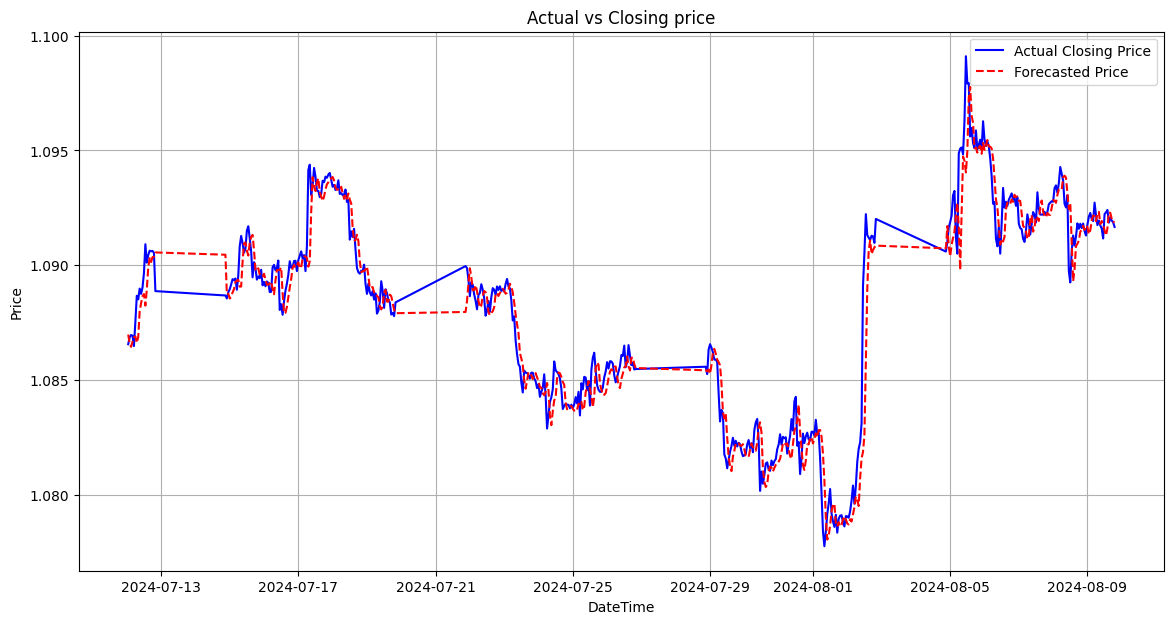

In [4]:
plt.figure(figsize=(14,7))
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Actual closing'], label='Actual Closing Price', color='blue')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Fore. Closing'], label= 'Forecasted Price', color = 'red',linestyle='--')
# plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['50 SMA'], label='50 EMA', color='green', linestyle='-')
# plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['200 SMA'], label='50 EMA', color='blue', linestyle='-')

plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Actual vs Closing price')
plt.legend()
plt.grid(True)
plt.show()

# Trading strategy and Signal generation

In [9]:
#generate trading signals -  store list of tuples
buy_signals =[]
sell_signals =[]


for i in range(len(y_test)):
    #enter long position
    if(y_pred_test.iloc[i] > y_test.iloc[i]):
        buy_signals.append((time_test.iloc[i], y_test.iloc[i]))
        sell_signals.append((None, None))
    #enter short position
    elif(y_pred_test.iloc[i] < y_test.iloc[i]):
        sell_signals.append((time_test.iloc[i], y_test.iloc[i]))
        buy_signals.append((None, None))
    #no trade opportunity
    else:
        sell_signals.append((None, None))
        buy_signals.append((None, None))

# Extract times and prices for plotting
buy_times = [signal[0] for signal in buy_signals if signal[0] is not None]
buy_prices = [signal[1] for signal in buy_signals if signal[1] is not None]
sell_times = [signal[0] for signal in sell_signals if signal[0] is not None]
sell_prices = [signal[1] for signal in sell_signals if signal[1] is not None]


# Plot buy and sell signals
plt.figure(figsize=(14,7))
# plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Actual closing'], label='Actual Closing Price', color='blue')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Fore. Closing'], label= 'Forecasted Price', color = 'blue')
# plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['Fore. Closing'], label= 'Forecasted Price', color = 'blue',linestyle='--')

plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['50 SMA'], label='50 SMA', color='green', linestyle='-')
plt.plot(resultsDataFrame['Date and Time'], resultsDataFrame['200 SMA'], label='200 SMA', color='blue', linestyle='-')


plt.scatter(buy_times, buy_prices, marker='^', color='green', label='Buy Signal', alpha=1)
plt.scatter(sell_times, sell_prices, marker='v', color='red', label='Sell Signal', alpha=1)

plt.xlabel('DateTime')
plt.ylabel('Price')
plt.title('Potential Signals for Consideration')
plt.legend()
plt.grid(True)
plt.show()


# Trade Execution and Returns evaluation - BackTesting

In [6]:
#iterate through test set
# buy signal? -> enter long : do not consider any other signal (record entry price)
# set stop loss and take profit
# go to next time step
#  - check price levels
#  - check has profit been reached? If not continue trade else
#  - check has price gone below SL -> If true,exit trade look for new signal
#  - else continue trade

# sell signal? -> enter short : do not consider any other signal (record entry price)
# set stop loss and take profit
# go to next time step
#  - check price levels
#  - check has profit been reached? If not continue trade else
#  - check has price gone above SL -> If true,exit trade look for new signal
#  - else continue trade

# no signal? -> don't enter long/short : consider any other signal (record entry price)
# go to next time step
#  - check price levels
#  - check has buy signa been made? ->enter long else
#  - check has sell signal been made? enter short else
#  - no buy or sell signal at current time step, go to next iteration(time step)

'''
Keep track of all the profits
K
'''


# for i in range(len(y_pred_test)):
#     if resultsDataFrame['Date and Time'].iloc[i] == 


'\nKeep track of all the profits\nK\n'